## Feature Engineering and Bag of Words. Building ML Baseline for NLP 
 - Explain the role of baseline model
 - Create a traditionalML solution with features and linear regression
 - Apply more advanced NLP techniques including SVR

### The importance of a Baseline 
- Start cheap and simple
- Gives benchmark to improve on
- An LLM might not be the right solution

### Traditional ML models 
#### Feature engineering & Linear Regression
What are the important factors which are likely to affect the price? and we'll come up with some pretty obvious features like how do they rank Amnazon's best seller rank.
And we will then try and see whether some linear combination of these features does a good job of predicting the price or not.
      
#### Bag of words & Linear Regression 
Which is one of the first forays into Natural Language Processing.     
NLP Bag of Words is a particularly simplistic approach, where you quite literally count up the number of words and you build yourself a little vector that consists of just how many times does each particular word feature in this description? (does not include stop words)             
i.e., Intel, it may indicate it is a laptop/desktop computer or CPU and that would have certain value.     
"Intel" might be one of the words in our vocab and depending on whether that appears or not or if it does, how many times it appears that will affect that location in this bag of words, this list of counts of words in each product.     
And then we're going to take that bag of words and again see if there's some linear combination of these different words that when combined together predicts the price of a product     
      
#### word2vec & Linear Regression   
One of the first real sort of a neural network, encoding algorithm that could produce a vector in a way that is rather smarter than a bag of words.     
          
#### word2vec & Random Forest 
Taking random chunks of your data and your features in the form of bits of vectors and creating an ensemble, a series of models that combines average across many of these little samples.     
      
#### word2vec & SVR  
Support Vector Machines, another technique, a specific way of trying to separate out your data into different groups.     
     
     
We will see which one of these techniques does best and how that fares in solving our problem of predicting the price. 

## Baseline Models in ML: Implementing Simple Prediction Functions

### The Product Pricer Continued

A model that can estimate how much something costs, from its description.

### Baseline Models

Simplest models to act as a starting point that we will beat.

In [32]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  
As described on StackOverflow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens).  
Many thanks to students Arnaldo G and Ard V for sorting this.

In [6]:
#!pip install gensim

In [7]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [8]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [9]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [10]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [11]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [12]:
%matplotlib inline

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files

If you didn't already create these in Day 2, you can also download them from my google drive (you'll also find the slides here):  
https://drive.google.com/drive/folders/1JwNorpRHdnf_pU0GE5yYtfKlyrKC3CoV?usp=sharing

But note that the files are quite large - you might need to get a coffee!

In [13]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [14]:
# Remind ourselves the training prompt

train[0].prompt

'How much does this cost to the nearest dollar?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7\n\nPrice is $227.00'

In [15]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [16]:
# Remind a test prompt

print(train[0].price)

226.95


## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [17]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

**color_for** function is to print in color      
**run_datapoint** gets the data point and guess (guess = self.predictor(datapoint)) the price and compares it with the actual price and then calculate the absolute error and squared log error.     

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random number generator!

In [18]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $374.41 Error: $280.59 SLE: 0.31 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $115.00 Truth: $225.11 Error: $110.11 SLE: 0.45 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $26.00 Truth: $61.68 Error: $35.68 SLE: 0.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $760.00 Truth: $599.99 Error: $160.01 SLE: 0.06 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $282.00 Truth: $16.99 Error: $265.01 SLE: 7.59 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $251.00 Truth: $31.99 Error: $219.01 SLE: 4.13 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $229.00 Truth: $101.79 Error: $127.21 SLE: 0.65 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $143.00 Truth: $289.00 Error: $146.00 SLE: 0.49 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $755.00 Truth: $635.86 Error: $119.14 SLE: 0.03 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $105.00 Truth: $65.99 Error: $39.01 S

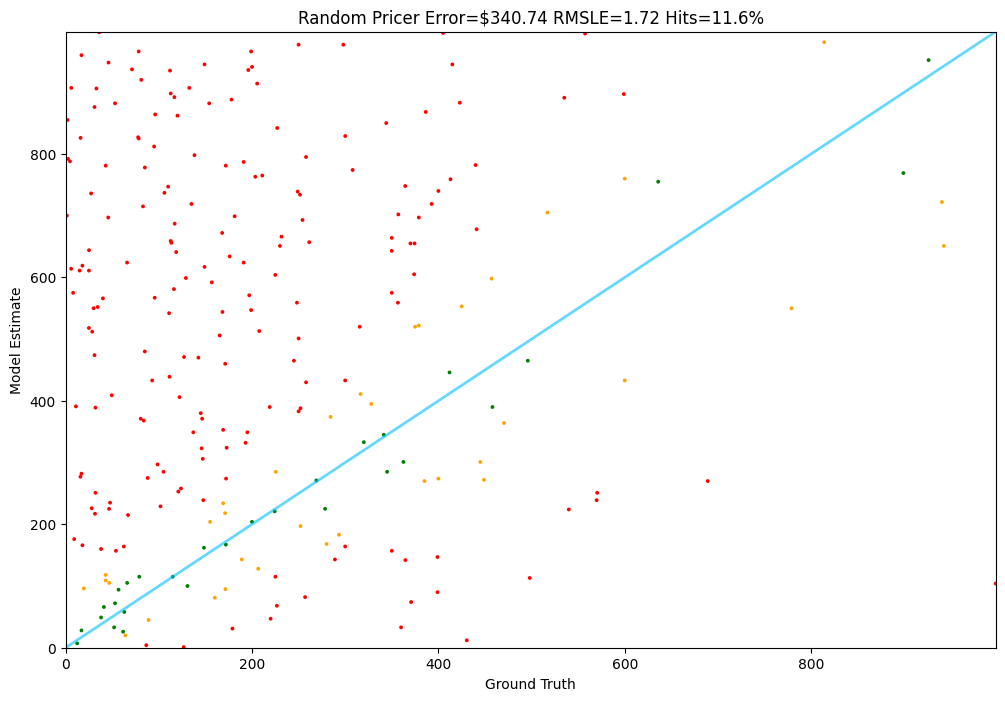

In [19]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

In [20]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $220.46 Truth: $374.41 Error: $153.95 SLE: 0.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $220.46 Truth: $225.11 Error: $4.65 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $220.46 Truth: $61.68 Error: $158.78 SLE: 1.59 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $220.46 Truth: $599.99 Error: $379.53 SLE: 1.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $220.46 Truth: $16.99 Error: $203.47 SLE: 6.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $220.46 Truth: $31.99 Error: $188.47 SLE: 3.63 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $220.46 Truth: $101.79 Error: $118.67 SLE: 0.59 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $220.46 Truth: $289.00 Error: $68.54 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.46 Truth: $635.86 Error: $415.40 SLE: 1.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $220.46 Truth: $65.99 Error: $154.47 S

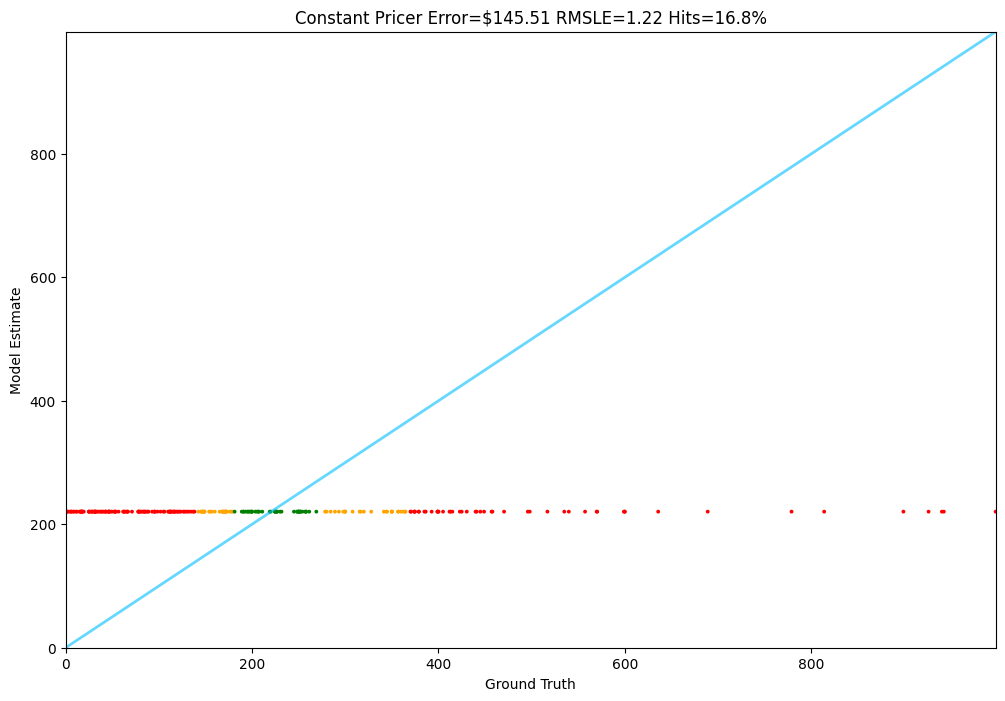

In [21]:
# Run our constant predictor
Tester.test(constant_pricer)

#### Feature Engineering     
LLM can make this easier. It used to be time consuming task in the Machine Learning 

In [22]:
train[0].details

'{"Brand": "Delphi", "Fit Type": "Vehicle Specific Fit", "Item Dimensions LxWxH": "19.7 x 7.7 x 5.1 inches", "Item Weight": "2.2 Pounds", "Auto Part Position": "Unknown", "Operation Mode": "Mechanical", "Manufacturer": "Delphi", "Model": "FUEL PUMP", "Product Dimensions": "19.7 x 7.7 x 5.1 inches", "Country of Origin": "USA", "Item model number": "FG0166", "Is Discontinued By Manufacturer": "No", "Exterior": "Painted", "Manufacturer Part Number": "FG0166", "OEM Part Number": "25326856, 89060639, A30416, E4061R, MU242", "Best Sellers Rank": {"Automotive": 913571, "Automotive Replacement Electric Fuel Pumps": 6568}, "Domestic Shipping": "Item can be shipped within U.S.", "International Shipping": "This item is not eligible for international shipping.  Learn More", "Date First Available": "August 9, 2006"}'

This appears to be a dictionary with keys and values but actually it is a string, a JSON blob representing a dictionary        
To add this "details" as a feature, we can use json.load package

In [23]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [25]:
train[0].features

{'Brand': 'Delphi',
 'Fit Type': 'Vehicle Specific Fit',
 'Item Dimensions LxWxH': '19.7 x 7.7 x 5.1 inches',
 'Item Weight': '2.2 Pounds',
 'Auto Part Position': 'Unknown',
 'Operation Mode': 'Mechanical',
 'Manufacturer': 'Delphi',
 'Model': 'FUEL PUMP',
 'Product Dimensions': '19.7 x 7.7 x 5.1 inches',
 'Country of Origin': 'USA',
 'Item model number': 'FG0166',
 'Is Discontinued By Manufacturer': 'No',
 'Exterior': 'Painted',
 'Manufacturer Part Number': 'FG0166',
 'OEM Part Number': '25326856, 89060639, A30416, E4061R, MU242',
 'Best Sellers Rank': {'Automotive': 913571,
  'Automotive Replacement Electric Fuel Pumps': 6568},
 'Domestic Shipping': 'Item can be shipped within U.S.',
 'International Shipping': 'This item is not eligible for international shipping.  Learn More',
 'Date First Available': 'August 9, 2006'}

In [24]:
train[0].features.keys()

dict_keys(['Brand', 'Fit Type', 'Item Dimensions LxWxH', 'Item Weight', 'Auto Part Position', 'Operation Mode', 'Manufacturer', 'Model', 'Product Dimensions', 'Country of Origin', 'Item model number', 'Is Discontinued By Manufacturer', 'Exterior', 'Manufacturer Part Number', 'OEM Part Number', 'Best Sellers Rank', 'Domestic Shipping', 'International Shipping', 'Date First Available'])

Now, there is a problem. Some items are sparse, missing, features

In [26]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 360062),
 ('Item Weight', 350444),
 ('Manufacturer', 349357),
 ('Brand', 340323),
 ('Best Sellers Rank', 330473),
 ('Item model number', 277573),
 ('Product Dimensions', 262400),
 ('Color', 183794),
 ('Is Discontinued By Manufacturer', 169828),
 ('Manufacturer Part Number', 145092),
 ('Material', 137447),
 ('Country of Origin', 121451),
 ('Style', 77639),
 ('Special Feature', 74709),
 ('Part Number', 74529),
 ('Batteries Required?', 73595),
 ('Package Dimensions', 72900),
 ('Item Dimensions LxWxH', 71385),
 ('Included Components', 67509),
 ('Model', 65144),
 ('Size', 58233),
 ('Item Package Quantity', 58149),
 ('Batteries Included?', 56779),
 ('OEM Part Number', 56062),
 ('Special Features', 53740),
 ('Exterior', 50566),
 ('Power Source', 50256),
 ('Vehicle Service Type', 49420),
 ('Finish Type', 46262),
 ('Voltage', 46036),
 ('Mounting Type', 38043),
 ('Model Name', 37524),
 ('Shape', 34816),
 ('Finish', 31901),
 ('Number of Items', 31871),
 ('Connectivity Te

Date First Available - 360000, Item weight-350000       
What are good candidates for features? we want consistently populated and meaningful to predict the price     
"Item Weight", "Brand", "Best Seller Rank" looks promising and we'll start with it.         
       
"Weight" in some cases pounds, kg, mg etc so we would like to have all of them in one unit

In [28]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [29]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [30]:
average_weight = sum(weights)/len(weights)
average_weight

13.57055237029551

Average weight is 13.5 pounds      
Why calculate average weight?       
When dealing with linear regression, there may be items which don't have weight and to replace those items with the average weight

In [31]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [33]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [34]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

380638.258828069

In [35]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

We previously did an exercise to see if there is any corelation between price and the length of text.       
It appeard to be a correlation.     

In [36]:
def get_text_length(item):
    return len(item.test_prompt())

In [37]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('HP', 5500),
 ('Power Stop', 3594),
 ('Dell', 3254),
 ('Detroit Axle', 2734),
 ('Lenovo', 2441),
 ('Dorman', 2116),
 ('SAMSUNG', 1772),
 ('BUYAUTOPARTS!', 1715),
 ('ACDelco', 1609),
 ('Evan Fischer', 1415),
 ('ASUS', 1387),
 ('Sony', 1282),
 ('Canon', 1201),
 ('Callahan BRAKE PARTS', 1154),
 ('Kohler', 1152),
 ('CURT', 1120),
 ('R1 Concepts', 1054),
 ('Rareelectrical', 966),
 ('Coverking', 941),
 ('Garage-Pro', 888),
 ('Kingston Brass', 852),
 ('Spectra Premium', 834),
 ('Moen', 829),
 ('Auto Dynasty', 824),
 ('WeatherTech', 822),
 ('DELTA FAUCET', 811),
 ('Generic', 793),
 ('Apple', 783),
 ('Cardone', 765),
 ('APS', 763),
 ('K&N', 758),
 ('GM', 743),
 ('Walker', 732),
 ('EBC Brakes', 717),
 ('AKKON', 646),
 ('SPEC-D TUNING', 626),
 ('TYC', 626),
 ('Covercraft', 618),
 ('Intel', 610),
 ('A-Premium', 607)]

In [38]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [39]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [40]:
# Look at features in a training item
get_features(train[0])

{'weight': 2.2,
 'rank': 460069.5,
 'text_length': 748,
 'is_top_electronics_brand': 0}

### Linear Regression

In [41]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

This is where we run traditional linear regression. 
We set our features and specify the names of the columns of our features.      
model= linear regression and then fit that model to our x values (features) and y values (actual prices) of our training data set.      
Then going to print the features and their coefficients or how much weight they got. So we can see that and get a sense of how important were each of our features.     
Then run prediction on the test set and get MSE (mean squared error) and the r-squared.     
       
Previously our average model, average guess had an error of $146 and hopefully linear regression can do better than average

In [42]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.2642321862957332
rank: 5.197480233116737e-05
text_length: 0.0076093283513202605
is_top_electronics_brand: 198.14254283206898
Intercept: 182.18661987897428
Mean Squared Error: 33034.336771967995
R-squared Score: 0.09091571194865222


So the difference or coefficient       
Weights- how heavy an item gets small positive weight.      
Ranks gets larger one.     
Text length gets a very low signal    
Top electronic brand - makes a big difference 

In [43]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $228.68 Truth: $374.41 Error: $145.73 SLE: 0.24 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $214.45 Truth: $225.11 Error: $10.66 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $191.46 Truth: $61.68 Error: $129.78 SLE: 1.26 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $389.92 Truth: $599.99 Error: $210.07 SLE: 0.18 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $211.35 Truth: $16.99 Error: $194.36 SLE: 6.09 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $211.42 Truth: $31.99 Error: $179.43 SLE: 3.47 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $190.88 Truth: $101.79 Error: $89.09 SLE: 0.39 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $190.14 Truth: $289.00 Error: $98.86 SLE: 0.17 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.89 Truth: $635.86 Error: $414.97 SLE: 1.11 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $199.88 Truth: $65.99 Error: $133.89 S

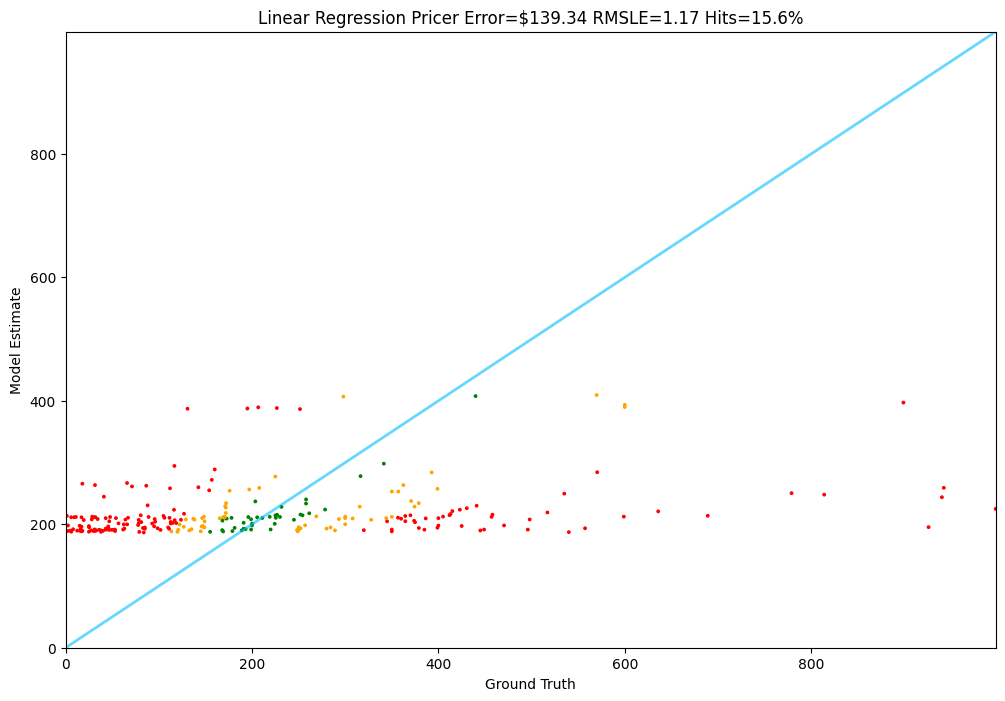

In [44]:
# test it

Tester.test(linear_regression_pricer)

Only a little bit better than the average      
It's clustered around the average kind of point with some of the points coming in about $200       
(probably "top electronics brands" )    
     
The error is \\$139 where the average model had an error of \\$146 

### Natural Language Processing 
#### Bag of Words   
      
we sill be focusing on Prices and documents       
Prices - List of all prices in our training dataset      
Documents - All of the test prompts from our training dataset      
      
We're going to build models which use the text in our documents instead of features       
**Note**: Text in the **test prompt**, not the text in **training** as it will contain the price as well

In [45]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

**CountVectorizer** counting the number of words and then build a vector. Where each location in the vector represents a particular word and then count how many times that word appears     
It looks like Bag of words that you are counting not in what order     
Count upto 1000 most common or most important of the words.     
Stop Words - and, the, in, it - that are not userful for the model and only a distraction    
Create our dataset     
Create a linear regression model      
Fit the bag of words to the prices

In [46]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

Put That into a bag of words, linear regression pricer

In [47]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $296.59 Truth: $374.41 Error: $77.82 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $165.14 Truth: $225.11 Error: $59.97 SLE: 0.09 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $162.26 Truth: $61.68 Error: $100.58 SLE: 0.92 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $326.15 Truth: $599.99 Error: $273.84 SLE: 0.37 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $51.69 Truth: $16.99 Error: $34.70 SLE: 1.15 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $74.06 Truth: $31.99 Error: $42.07 SLE: 0.68 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $344.83 Truth: $101.79 Error: $243.04 SLE: 1.47 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $241.39 Truth: $289.00 Error: $47.61 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $404.57 Truth: $635.86 Error: $231.29 SLE: 0.20 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $111.12 Truth: $65.99 Error: $45.13 SLE: 0

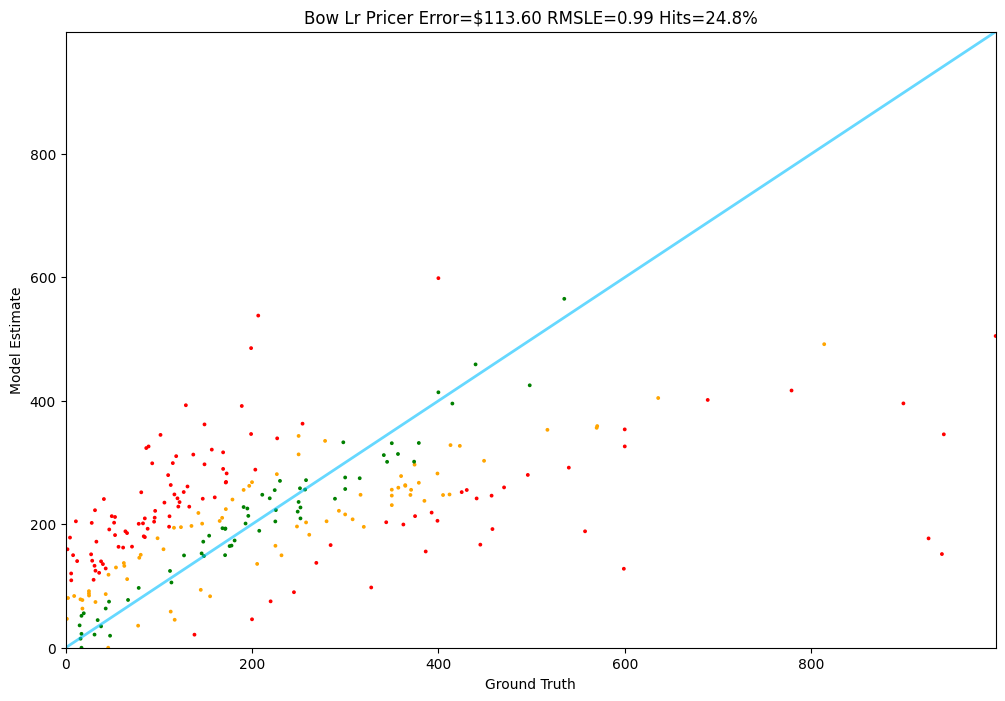

In [48]:
# test it

Tester.test(bow_lr_pricer)

Lot more green dots and the average is $113, better than linear regression with featues

#### Word2Vec

Before we go into more advanced models, Gensim library, word to vec model        
We are going to build vectors with 400 dimensions, set to use eight workers

In [49]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [50]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [51]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [52]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $229.37 Truth: $374.41 Error: $145.04 SLE: 0.24 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $167.33 Truth: $225.11 Error: $57.78 SLE: 0.09 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $161.21 Truth: $61.68 Error: $99.53 SLE: 0.90 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $358.45 Truth: $599.99 Error: $241.54 SLE: 0.26 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $101.54 Truth: $16.99 Error: $84.55 SLE: 3.03 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $306.95 Truth: $101.79 Error: $205.16 SLE: 1.20 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $247.64 Truth: $289.00 Error: $41.36 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $338.41 Truth: $635.86 Error: $297.45 SLE: 0.40 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $129.26 Truth: $65.99 Error: $63.27 SLE: 

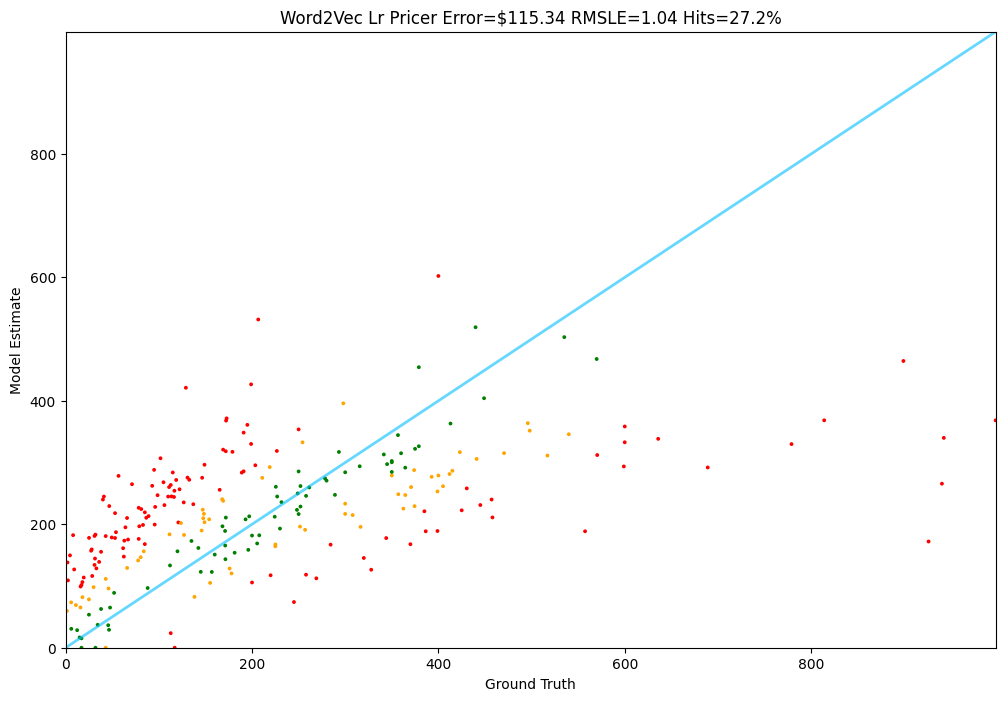

In [53]:
Tester.test(word2vec_lr_pricer)

It is little bit worse than linear regression based on the simple bag of words model      
It may be that Linear Regresson model is unable take the extra  word2vec vectors extra information     

### Support Vector Regression vs Random Forest

In [54]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [55]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $237.95 Truth: $374.41 Error: $136.46 SLE: 0.20 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $162.65 Truth: $225.11 Error: $62.46 SLE: 0.10 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $138.05 Truth: $61.68 Error: $76.37 SLE: 0.63 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $300.43 Truth: $599.99 Error: $299.56 SLE: 0.48 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $54.05 Truth: $16.99 Error: $37.06 SLE: 1.25 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $245.27 Truth: $101.79 Error: $143.48 SLE: 0.76 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $176.27 Truth: $289.00 Error: $112.73 SLE: 0.24 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $281.29 Truth: $635.86 Error: $354.57 SLE: 0.66 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $99.01 Truth: $65.99 Error: $33.02 SLE: 0

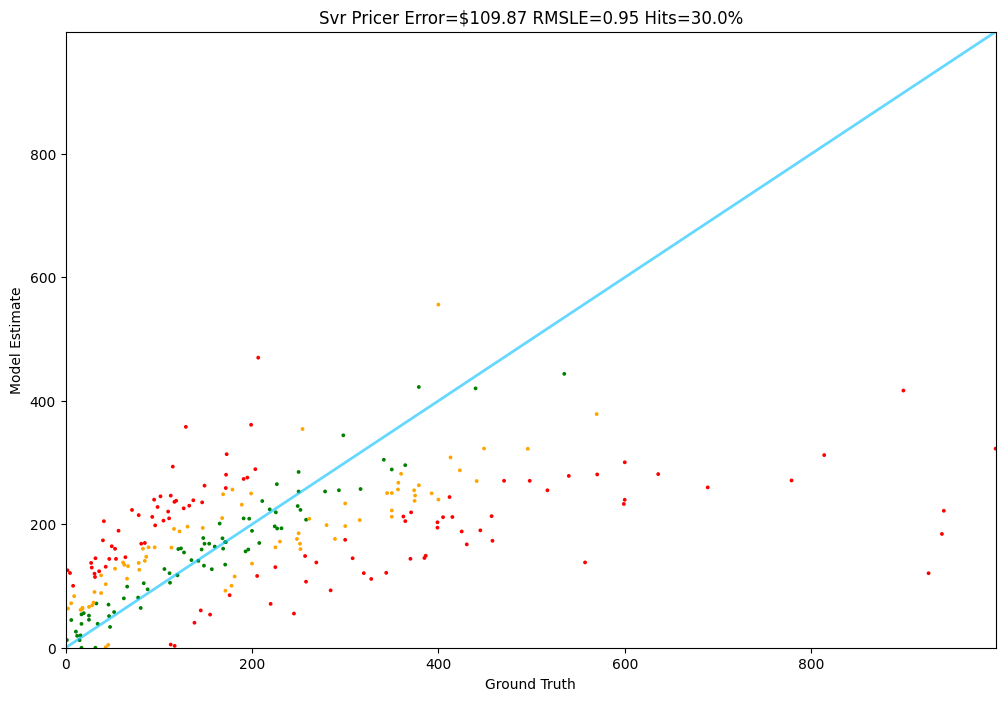

In [56]:
Tester.test(svr_pricer)

In [57]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

RandomForestRegressor(n_jobs=8, random_state=42)

In [58]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $312.11 Truth: $374.41 Error: $62.30 SLE: 0.03 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $196.47 Truth: $225.11 Error: $28.64 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $179.28 Truth: $61.68 Error: $117.60 SLE: 1.12 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $352.97 Truth: $599.99 Error: $247.02 SLE: 0.28 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $163.38 Truth: $16.99 Error: $146.39 SLE: 4.89 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $50.57 Truth: $31.99 Error: $18.58 SLE: 0.20 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $301.13 Truth: $101.79 Error: $199.34 SLE: 1.16 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $216.60 Truth: $289.00 Error: $72.40 SLE: 0.08 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $289.57 Truth: $635.86 Error: $346.29 SLE: 0.62 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $126.39 Truth: $65.99 Error: $60.40 SLE:

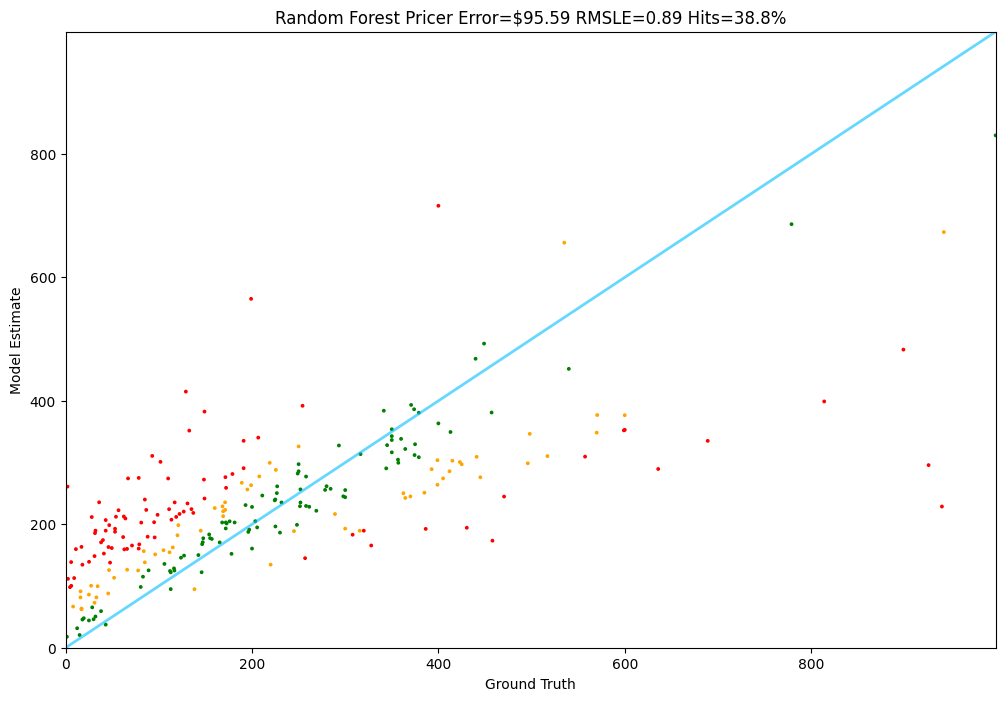

In [59]:
Tester.test(random_forest_pricer)

The error is $96 and the best so far

![](images/model_errors.png)